In [1]:
import pandas_datareader as pdr
import requests
import pandas as pd
from datetime import datetime, timedelta
import sqlite3 
import sql_tools
import time
import numpy as np
from IPython.display import clear_output
import matplotlib.pylab as plt
import seaborn as sea
pick = sql_tools.IcePick(sqlite3, 'trade_history.sqlite')
con = sqlite3.connect('trade_history.sqlite')
phi = (1 + np.sqrt(5))/2

In [2]:
def download_data(ticker, data_source = 'yahoo',  *args, **kwargs):
    i = 0
    while True:
        try:
            print('Trying to Download: {}'.format(ticker))
            data = pdr.DataReader(ticker, data_source, *args, **kwargs)
            return data
        except pdr.base.RemoteDataError as e:
            i = i + 1
            print(e)
            print('Error {} : Exponential Backoff time: {}'.format(i , i**2))
            
            if i > 7:
                print('Error Got too big, raising it')
                raise e 
            time.sleep(i ** 2)
            
bar_pos = 0            
def progress_bar(i, left):
    
    global bar_pos
    bar_pos = bar_pos + 1
    power_of_one_dot = 100/left
    pos = int(power_of_one_dot * i)
    bar = ''

    for num in range(0, pos -1 ):
        if (num + bar_pos) %2 == 0:
            bar = bar + '-'
        if (num + bar_pos) %2 != 0:
            bar = bar + '🚃'             
    bar = bar + '🚢'
    for num in range(0, 100 - pos):
        bar = bar + ' '
    bar = '-' + bar
    bar = bar + '| {:.2f} % \nDone: {} Remaining: {}'.format(100 * i/(left -1), i, left - i )
    print(bar)



In [3]:
def download_tickers():
    nyse = pd.read_csv('http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NYSE&render=download')
    nasdaq = pd.read_csv('http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ&render=download')
    data = nyse.append(nasdaq)
    data['Symbol']= data['Symbol'].str.replace(' ', '')
    data = data.set_index('Symbol')
    data = data[~data.index.duplicated()]
    data = data[~data.index.str.contains('\^')]
    data = data[~data.index.str.contains('\.')]
    data = data[~data.index.str.contains('\~')]
    data = data[data['MarketCap'] > 0]
    del data['Unnamed: 9']
    data['table_name'] = '_'+ data.index + '_'
    return data
tickers = download_tickers()

def create_updates(tickers):
    updates = pd.DataFrame(index = set(tickers))
    updates['last_updated'] = datetime(2018,1,24)
    updates.index.name = 'ticker'
    updates.to_sql('tickers', con, if_exists='replace')
    

def save_timestamp(ticker, time):
    with pick.get_connection() as cur:
        sql = "CREATE TABLE IF NOT EXISTS tickers (id text primary key, ticker text, last_updated text);"
        cur.execute(sql)
        
    with pick.get_connection() as cur:
        sql = """
        INSERT OR REPLACE INTO tickers(id, ticker, last_updated)
        Values ('{}', '{}', '{}')
        """.format( '_' + ticker + '_', ticker, time)
        cur.execute(sql)
    return

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
def save_data(data, ticker = None, kind = ''):
    ''' kind must be one of:update, reset '''
    ok_types = ['update', 'reset']
    if kind not in ok_types:
        raise ValueError( ' argument kind must be one of the following: {}'.format(','.join(ok_types)))
    if (type(data) == pd.DataFrame) and (type(ticker) == type(None)):
        raise ValueError( 'Must Specify ticker argument with type = \'Dataframe\'')
    if type(data) == pd.core.panel.Panel:
        for ticker in data.minor_axis:
            candles = data.minor_xs(ticker)
            save_data(candles, ticker, kind)
            
    if type(data) == pd.DataFrame:
        _ticker_ = '_' + ticker + '_'
        data.columns = data.columns.str.replace(' ', '_')
        data = data.fillna("'nan'").replace('nan', "'nan'")
        if kind == 'reset':
            with pick.get_connection() as con:
                sql = "DROP TABLE IF EXISTS {} ".format(_ticker_)
                con.execute(sql)
            with pick.get_connection() as con:    
                sql = """ create table {} (Date text primary key,
                Open real ,High real ,Low real ,
                Close real ,Adj_Close real, Volume real )""".format(_ticker_)
                con.execute(sql)
            kind = 'update'
            
        if kind == 'update':
            
            column_names = list([data.index.name]) + list(data.columns)
            sql = """ INSERT OR REPLACE INTO {}({})\nValues """.format(_ticker_,','.join(column_names) )
            value_bit = []
            for date in data.index:
                row = data.loc[date]
                others = ','.join(row.apply(str).values)
                value_bit.append( " ('{}', {} )".format(date, others))
            sql = sql + ',\n'.join(value_bit)
            with pick.get_connection() as con:
                con.execute(sql)
                con.commit()


        latest_date = data.index.max()
        save_timestamp(ticker, latest_date)
    return 
        

In [4]:
def update_tickers(to_date):
    t = pd.to_datetime
    to_date = t(t(to_date).strftime('%Y-%m-%d'))
    tables = pick.get_data('tickers')
    tables = tables.set_index('table_name')
    tables['last_updated'] = pd.to_datetime(tables['last_updated'])

    tables['need_update'] = tables['last_updated'] < to_date
    tables=  tables[tables['need_update']]
    
    i = 0
    batch_size = 10
    to_do_length = len(tables)
    for thing in batch(tables, batch_size):
        downloaded_data = download_data(thing.index)
        downloaded_data = pd.DataFrame()
        save_data(downloaded_data, kind = 'update')
        
        i = min(i + batch_size, to_do_length)
        progress_bar(i,to_do_length)
        clear_output(True)
        
    return tables
#x = update_tickers(datetime.today())

In [5]:
def load_ticker(ticker):
    if '_' not in ticker:
        ticker = '_{}_'.format(ticker)
    data = pick.get_data(ticker).set_index('Date')
    for column in data.columns:
        try:
            mask = data[column].apply(str).str.contains('nan')
            data.loc[mask, column] = np.nan
        except TypeError:
            pass
    data.index = pd.to_datetime(data.index)
    return data



In [21]:
def similar(ticker,sector = True, industry = True , tickers = tickers  ):
    current = tickers.loc[ticker]
    mask = tickers['MarketCap'] > 0
    if sector:
        mask = mask & (tickers['Sector'] == current['Sector'])
    if industry:
        mask = mask & (tickers['Industry'] == current['Industry'])   
    return tickers[mask]

data = similar('JCP',sector= False, industry = True).sort_values('MarketCap')

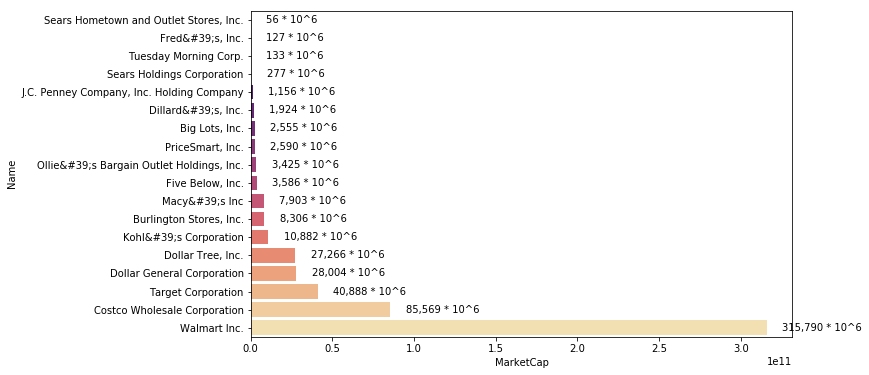

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(6 * phi, 6)
sea.barplot(data['MarketCap'], data['Name'], palette='magma')
for i, market_cap in enumerate(data['MarketCap']):
    plt.text(market_cap + max(data['MarketCap']) *.03,i, '{:,.0f} * 10^6'.format(market_cap/1000000), va = 'center', ha = 'left')
plt.show()

In [81]:
symbols = download_data(data.index, start = datetime(2001, 1, 1))

Trying to Download: Index(['SHOS', 'FRED', 'TUES', 'SHLD', 'JCP', 'DDS', 'BIG', 'PSMT', 'OLLI',
       'FIVE', 'M', 'BURL', 'KSS', 'DLTR', 'DG', 'TGT', 'COST', 'WMT'],
      dtype='object', name='Symbol')


In [82]:
final = pd.DataFrame()
keep = ['JCP', 'M', 'SHOS', 'SHLD']
for symbol in symbols.minor_axis:
    
    if symbol in keep:
        final[symbol] = symbols.minor_xs(symbol)['Close']
    
final = final.ffill()

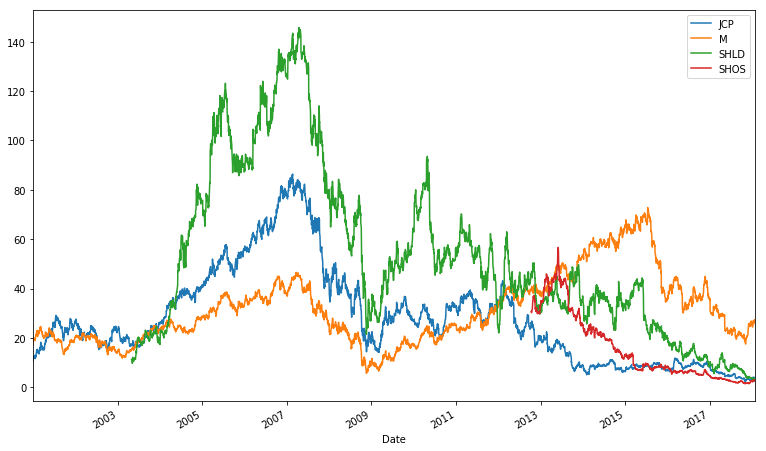

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(8 * phi, 8)
final.plot(ax = ax)
plt.show()

In [7]:
start = datetime(2001, 1,1)

In [8]:
m = download_data('M',start = start)['Close']
jcp  = download_data('JCP',start = start)['Close']
shos  = download_data('shos',start = start)['Close']

Trying to Download: M
Trying to Download: JCP
Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/JCP?period1=978336000&period2=1517558399&interval=1d&events=history&crumb=p%5Cu002FHVgxS1f6N
Error 1 : Exponential Backoff time: 1
Trying to Download: JCP
Trying to Download: shos
Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/shos?period1=978336000&period2=1517558399&interval=1d&events=history&crumb=4p792tu%5Cu002FKD.
Error 1 : Exponential Backoff time: 1
Trying to Download: shos


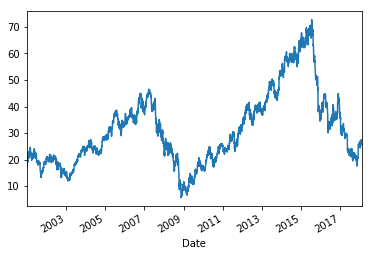

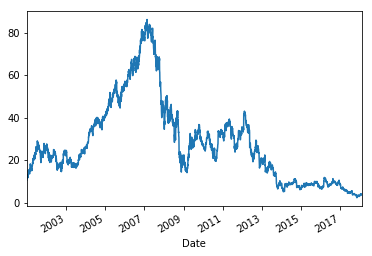

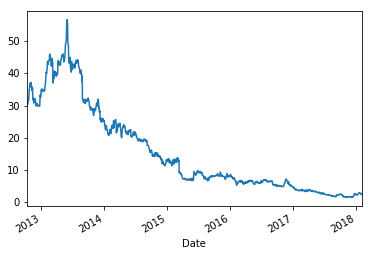

In [9]:
m.plot()
plt.show()

jcp.plot()
plt.show()

shos.plot()
plt.show()

In [116]:
amd = download_data('AMD')[['Close']]

Trying to Download: AMD


In [ ]:
amd

In [119]:
amd = download_data('AMD')[['Close']]
amd = amd.pct_change()
amd = amd[~amd['Close'].isnull()]

Trying to Download: AMD


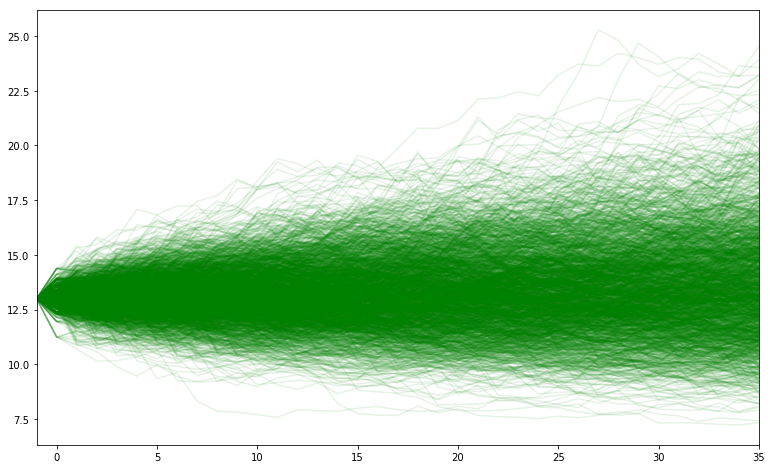

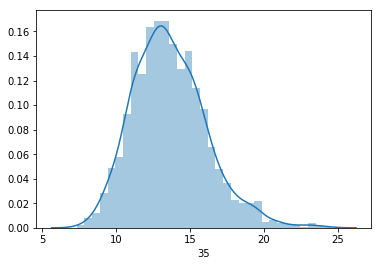

count    2000.000000
mean       13.631578
std         2.495220
min         7.337638
25%        11.846958
50%        13.404582
75%        15.144778
max        24.545510
Name: 35, dtype: float64
Chance of Being above: 0.407
Chance of Being below: 0.593


In [125]:
price = 13
days = 36
point = 14

def apply_price(change):
    global price
    price = price + (price * change)
    return price

def stochastic_model(days, sample_set):
    
    model = pd.DataFrame()
    for num in range(0, 2000):
        global price
        start_price  = price
        changes = sample_set.sample(days, replace = True).reset_index(drop = True)
        model[num] = changes['Close'].apply(apply_price)
        price = start_price
    model.loc[-1] = price
    model = model.sort_index()
    return model

fig, ax = plt.subplots()
fig.set_size_inches(8 * phi, 8 )
model = stochastic_model(days, sample_set = amd.loc['2017-6-1':])
model.plot(ax = ax, alpha = 0.1, color = 'green')
ax.legend_.remove()
plt.show()
to_see = model.loc[days - 1]

sea.distplot(to_see)
plt.show()
print(to_see.describe())

above = len(to_see[to_see > point])/len(to_see)
print('Chance of Being above: {}'.format(above))

below = len(to_see[to_see < point])/len(to_see)
print('Chance of Being below: {}'.format(below))

In [126]:
def simlate_based_on_price(to_see, point, price):
    
    for num in range(1000):
        result = to_see.sample(1)
        if result < point:
            

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
-1,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
0,12.873598,13.885214,14.378165,12.808999,13.272991,12.832449,13.309524,12.513029,13.614329,14.112757,...,13.117987,12.915447,12.604297,14.378165,13.913701,13.211382,13.323502,13.264890,13.565673,13.378221
1,12.610074,13.551726,14.313515,12.515165,13.341916,12.867162,12.601669,12.399618,13.525274,14.240843,...,13.420419,12.200719,12.496798,14.021594,13.787595,13.656210,13.522535,12.596548,13.402347,13.532814
2,12.895945,13.589847,14.602260,12.703520,13.588076,12.553554,12.350640,12.427566,13.206031,14.579911,...,13.803859,12.549809,12.822287,13.657693,13.131043,13.592791,13.798073,12.616735,13.292491,13.222376
3,12.412872,13.608987,14.509514,12.539790,13.792579,12.519098,12.059122,12.462524,13.146651,14.327847,...,13.825981,12.301298,13.157124,13.457029,13.160640,13.083615,13.760201,12.775579,13.333141,13.431219
4,12.676176,13.392791,14.998050,12.378170,14.110564,12.341892,12.175168,11.834609,13.234631,14.374747,...,13.472166,12.365177,13.329991,13.535040,13.126006,14.203529,13.798907,12.966427,14.227200,13.751009
5,12.037496,13.305683,15.022085,12.469119,14.439244,12.359275,12.423252,11.391293,12.836439,14.126230,...,14.058385,12.389639,13.419197,13.854847,13.298465,14.904482,13.482068,13.304147,14.581241,14.328596
6,11.970086,12.991623,15.377028,12.613207,14.388258,11.765263,12.579660,12.191926,12.887785,14.255947,...,13.758129,12.105424,13.309204,14.828631,12.923238,14.757156,13.137029,12.990123,14.997848,14.667153
7,11.673234,12.669438,15.279293,12.497778,14.270233,11.478511,12.420067,12.468318,12.495498,13.797767,...,13.536760,12.451294,12.995061,15.130781,13.476332,15.100897,12.693211,13.313380,15.142174,14.744757
8,11.942358,12.473413,15.719716,12.453648,14.572935,11.721995,13.064825,12.366118,12.859041,13.522911,...,13.405138,12.576537,13.113003,14.143685,13.279528,16.121704,12.766794,13.383821,14.898535,14.367431


In [179]:
spy = download_data("SPY", start = datetime(2005, 1,1))
xlf = download_data('XLF', start = datetime(2005, 1,1))
vix = download_data('ViX', start = datetime(2005, 1,1))

Trying to Download: SPY
Trying to Download: XLF
Trying to Download: ViX


In [180]:
def indicators(data, slow = 26, fast = 12):
    data = data.sort_index()
    data['moving_average'] = data['Close'].rolling(9).mean()
    data['fast'] = data['Close'].ewm( span = fast,min_periods=1,adjust=True,ignore_na=False).mean()
    data['slow'] = data['Close'].ewm( span= slow,min_periods=1,adjust=True,ignore_na=False).mean()
    data = data.ffill()
    return data

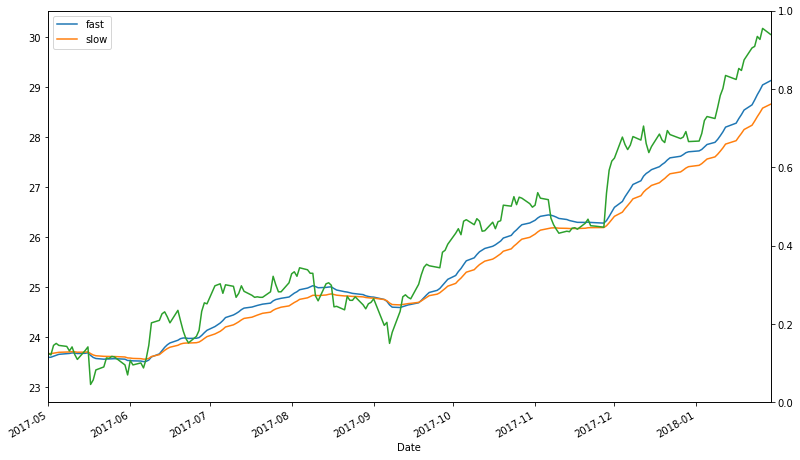

In [211]:
final = xlf.copy()


fig, ax = plt.subplots()
fig.set_size_inches(8 * phi, 8 )


period = 23
final = indicators(final, int(period * phi ),period)
final = final.dropna()


x = final.loc['2017-05-01':]
x[['fast', 'slow']].plot(ax = ax)
x['Close'].plot(ax = ax)
x2 = ax.twinx()
x['Volume'].plot(ax = ax2)



plt.show()